<a href="https://colab.research.google.com/github/Kulbina/Deepfake/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/ageitgey/face_recognition.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ageitgey/face_recognition.git to /tmp/pip-req-build-8h0zltn3
  Running command git clone -q https://github.com/ageitgey/face_recognition.git /tmp/pip-req-build-8h0zltn3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import os
import glob
import json
import face_recognition

import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm_notebook
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
import sklearn

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Deepfake

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Deepfake


In [ ]:
# Установка face_recognition
# https://gist.github.com/jk195417/76afbb7ac8ce30afb04bcd72eafc5aff

# Пример использования face_recognition

In [ ]:
!ls 'dataset/women/Angelina Jolie'

Image_10.jpg  Image_13.jpg  Image_1.jpg  Image_4.JPG  Image_7.jpg
Image_11.jpg  Image_14.jpg  Image_2.jpg  Image_5.jpg  Image_8.jpg
Image_12.jpg  Image_15.jpg  Image_3.jpg  Image_6.jpg  Image_9.jpg


In [ ]:
# загружаем при помощи face_recognition изображение
image = face_recognition.load_image_file("./dataset/women/Angelina Jolie/Image_10.jpg")

# получаем координаты расположения лица
# return (top, right, bottom, left)
face_locations = face_recognition.face_locations(image)

In [ ]:
# начало координат
xy = (face_locations[0][3], face_locations[0][0])

# получаем ширину и высоту
width = face_locations[0][1] - face_locations[0][3]
height = face_locations[0][2] - face_locations[0][0]

In [ ]:
face_locations

[(22, 108, 65, 64)]

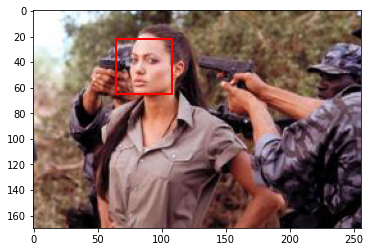

In [ ]:
plt.imshow(image)

# Получение текущей ссылки 
ax = plt.gca()

# Добавление прямоугольника, где расположено лицо
rect = patches.Rectangle(xy, width, height, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect);

# Импорт данных

In [ ]:
with open('config/actress_actors.json', 'r') as fp:
    dict_act = json.load(fp)

In [ ]:
# Нумерация имен в словаре
dict_labels = dict()
for i, key in enumerate(dict_act['women']):
    dict_labels[key] = i
    
dict_labels

{'Alicia Vikander': 0,
 'Amy Adams': 1,
 'Andie MacDowell': 2,
 'Angelina Jolie': 3,
 'Anne Hathaway': 4,
 'Cameron Diaz': 5,
 'Carey Mulligan': 6,
 'Cate Blanchett': 7,
 'Catherine Zeta-Jones': 8,
 'Charlize Theron': 9,
 'Claire Forlani': 10,
 'Demi Moore': 11,
 'Drew Barrymore': 12,
 'Elizabeth Taylor': 13,
 'Emma Stone': 14,
 'Eva Mendes': 15,
 'Frances McDormand': 16,
 'Gwyneth Paltrow': 17,
 'Halle Berry': 18,
 'Hilary Swank': 19,
 'Jennifer Aniston': 20,
 'Jessica Biel': 21,
 'Jessica Chastain': 22,
 'Jodie Foster': 23,
 'Julia Roberts': 24,
 'Julianne Moore': 25,
 'Juliette Binoche': 26,
 'Kate Winslet': 27,
 'Keira Knightley': 28,
 'Kim Basinger': 29,
 'Kirsten Dunst': 30,
 'Kristin Scott Thomas': 31,
 "Lupita Nyong'o": 32,
 'Maggie Gyllenhaal': 33,
 'Marion Cotillard': 34,
 'Meg Ryan': 35,
 'Megan Fox': 36,
 'Melanie Laurent': 37,
 'Meryl Streep': 38,
 'Michelle Pfeiffer': 39,
 'Milla Jovovich': 40,
 'Naomi Watts': 41,
 'Natalie Portman': 42,
 'Natasha Henstridge': 43,
 'Nicol

In [ ]:
embedings = np.empty(128)
target = []

key = 'women'

for person in tqdm_notebook(list(dict_labels.keys())):
    files = len(glob.glob(f'dataset/women/{person}/*'))   
    if files < 2:
        print(f'Убираем из датасета: {person}')
    else:
        # получаем список изображений внутри папки
        images = os.listdir(f"./dataset/{key}/{person}")
        len_images = len(images)

        for num, person_img in enumerate(images):
            try:
                if person_img != '.DS_Store':
                    # Считыаем изображение
                    face = face_recognition.load_image_file(
                        f"dataset/{key}/{person}/{person_img}")
                    # Получаем координаты лица
                    face_bounding_boxes = face_recognition.face_locations(face)

                    # Если более одного лица на фото, либо их нет, то пропуск
                    if len(face_bounding_boxes) == 1:
                        try:
                            # Преобразуем фото с лицом в вектор, получаем embeding
                            face_enc = face_recognition.face_encodings(face)[0]

                            # Добавляем в датасет матрицу
                            embedings = np.vstack((embedings, face_enc))

                            # Добавляем таргет по текущему индексу
                            target.append(dict_labels[person])

                        except Exception as ex:
                            print(f'Error message {ex}')
            except Exception as ex:
                print(f'Error message {ex}')

<ipython-input-16-d6fee35785e5>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for person in tqdm_notebook(list(dict_labels.keys())):


  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
# Удаляем из датасета первый элемент, так как это пустая матрица
embedings_ = embedings[1:]

In [ ]:
embedings_.shape

(788, 128)

In [ ]:
len(target)

788

In [ ]:
with open('static/embedings.pkl','wb') as f:
    pickle.dump(embedings_, f)
    
with open('static/labels.pkl','wb') as f:
    pickle.dump(target, f)

In [ ]:
with open('static/embedings.pkl','rb') as f:
    embedings_ = pickle.load(f)
    
with open('static/labels.pkl','rb') as f:
    target = pickle.load(f)

In [ ]:
dict_labels

{'Alicia Vikander': 0,
 'Amy Adams': 1,
 'Andie MacDowell': 2,
 'Angelina Jolie': 3,
 'Anne Hathaway': 4,
 'Cameron Diaz': 5,
 'Carey Mulligan': 6,
 'Cate Blanchett': 7,
 'Catherine Zeta-Jones': 8,
 'Charlize Theron': 9,
 'Claire Forlani': 10,
 'Demi Moore': 11,
 'Drew Barrymore': 12,
 'Elizabeth Taylor': 13,
 'Emma Stone': 14,
 'Eva Mendes': 15,
 'Frances McDormand': 16,
 'Gwyneth Paltrow': 17,
 'Halle Berry': 18,
 'Hilary Swank': 19,
 'Jennifer Aniston': 20,
 'Jessica Biel': 21,
 'Jessica Chastain': 22,
 'Jodie Foster': 23,
 'Julia Roberts': 24,
 'Julianne Moore': 25,
 'Juliette Binoche': 26,
 'Kate Winslet': 27,
 'Keira Knightley': 28,
 'Kim Basinger': 29,
 'Kirsten Dunst': 30,
 'Kristin Scott Thomas': 31,
 "Lupita Nyong'o": 32,
 'Maggie Gyllenhaal': 33,
 'Marion Cotillard': 34,
 'Meg Ryan': 35,
 'Megan Fox': 36,
 'Melanie Laurent': 37,
 'Meryl Streep': 38,
 'Michelle Pfeiffer': 39,
 'Milla Jovovich': 40,
 'Naomi Watts': 41,
 'Natalie Portman': 42,
 'Natasha Henstridge': 43,
 'Nicol

In [ ]:
len(target)

788

In [ ]:
#embedings_ = embedings_[1:]

In [ ]:
embedings_.shape


(788, 128)

# Обучение модели

In [ ]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 1.0.2.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    embedings_, target, test_size=0.3, stratify=target, random_state=42)
X_train.reshape(70528)
X_test.reshape(30336)

array([-0.10780418,  0.04519979,  0.13969199, ..., -0.06366195,
        0.03308488,  0.11489169])

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [ ]:
f1 = f1_score(y_test, clf.predict(X_test), average='micro')

print(f'F1 score = {f1}')

F1 score = 0.6540084388185654


# Тестирование на реальном фото

In [ ]:
def resize_image(SIZE, image):
    # получим его размер
    size = image.size

    # получим коэффициент, на который нужно уменьшить/увеличить
    # изображение по одной из сторон до 256
    coef = SIZE / size[0]
    # изменяем размер изображения
    resized_image = image.resize(
        (int(size[0] * coef), int(size[1] * coef)))
    res_image = resized_image.convert('RGB')
    return res_image

In [ ]:
SIZE = 1024

image = Image.open('test image/image1.jpg')
res_image = resize_image(SIZE, image)
res_image.save('test image/image1.jpg')

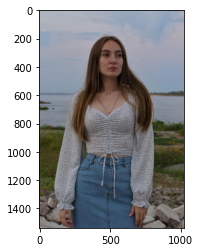

In [ ]:
plt.imshow(res_image);

In [ ]:
def predict_actress(path, model, dict_labels):
    face = face_recognition.load_image_file(path)
    face_bounding_boxes = face_recognition.face_locations(face)
    
    if len(face_bounding_boxes) != 1:
        print('Problem with find face')
    else:
        # Преобразуем фото с лицом в вектор, получаем embeding 
        face_enc = face_recognition.face_encodings(face)[0]
        
        # Предикт actress/actor
        predict = clf.predict([face_enc])
        predict_labels = list(dict_labels.keys())[list(dict_labels.values()).index(predict)]
        
        preict_proba = clf.predict_proba([face_enc])
        
        return predict_labels, preict_proba

In [ ]:
predict_name, preict_proba = predict_actress('test image/image1.jpg', clf, dict_labels)
predict_name

'Nina Dobrev'

In [ ]:
# таблица с оценками
df = pd.DataFrame()

df['act'] = list(dict_labels.keys())
df['score'] = preict_proba[0]

In [ ]:
df.sort_values(by='score')[::-1]

,act,score
45,Nina Dobrev,0.027251
53,Scarlett Johansson,0.026706
36,Megan Fox,0.026490
11,Demi Moore,0.025319
23,Jodie Foster,0.024797
...,...,...
58,Viola Davis,0.009978
6,Carey Mulligan,0.009875
18,Halle Berry,0.009867
35,Meg Ryan,0.008972


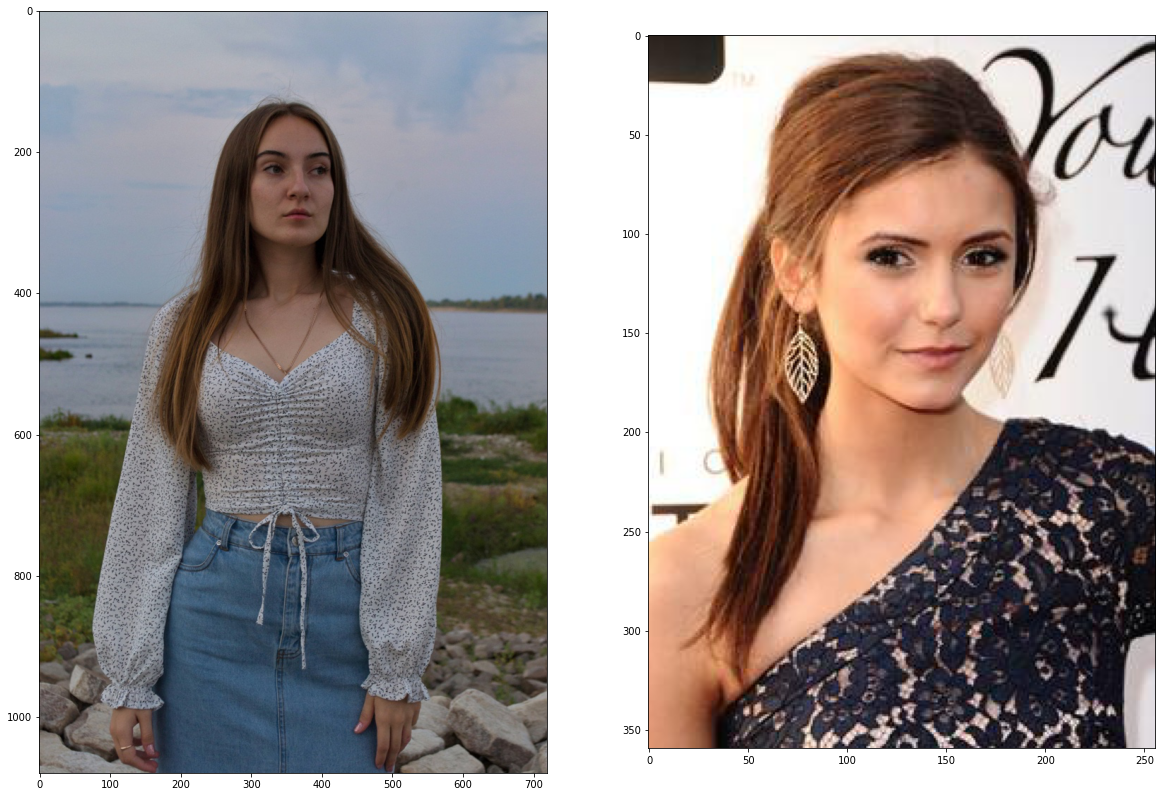

In [ ]:
num_image = 11

image1 = face_recognition.load_image_file("test image/image1_res.jpg")
image2 = face_recognition.load_image_file(f"dataset/women/{predict_name}/Image_{num_image}.jpg")

fig, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(image1)
ax[1].imshow(image2);

# Получение средней оценки cosine

In [ ]:
def comparison(path_test, name_act, num_image):
    # лицо в качестве теста
    face_1 = face_recognition.load_image_file(path_test)
    face_enc_1 = face_recognition.face_encodings(face_1)[0]
    
    # актриса
    path_act = f"dataset/women/{name_act}/Image_{num_image}.jpg"
    
    face_2 = face_recognition.load_image_file(path_act)
    face_enc_2 = face_recognition.face_encodings(face_2)[0]
    
    return cosine_similarity(face_enc_1.reshape(1, -1), face_enc_2.reshape(1, -1))[0]

In [ ]:
len_files = len(glob.glob(f'dataset/women/{predict_name}/*'))
cos = []

for i in tqdm_notebook(range(len_files)):
    try:
        cos_ = comparison('test image/image1_res.jpg', predict_name, i)
        cos.append(cos_)
        print(i, cos_)
    except Exception as ex:
        print(f'message: {ex}')
        
print(f'Mean score = {np.mean(cos)}')

<ipython-input-59-237b7c34f4d2>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len_files)):


  0%|          | 0/15 [00:00<?, ?it/s]

message: [Errno 2] No such file or directory: 'dataset/women/Nina Dobrev/Image_0.jpg'
1 [0.86530782]
2 [0.85918364]
3 [0.88995445]
4 [0.89948377]
5 [0.86766791]
6 [0.85865452]
7 [0.86527165]
8 [0.88625923]
9 [0.87423687]
10 [0.89391905]
11 [0.88637222]
12 [0.85309248]
13 [0.88959217]
14 [0.88492158]
Mean score = 0.8767083814505401


In [ ]:
predict_name = 'Demi Moore'

len_files = len(glob.glob(f'dataset/women/{predict_name}/*'))
cos = []

for i in tqdm_notebook(range(len_files)):
    try:
        cos_ = comparison('test image/image1_res.jpg', predict_name, i)
        cos.append(cos_)
        print(i, cos_)
    except Exception as ex:
        print(f'message: {ex}')
        
print(f'Mean score = {np.mean(cos)}')

<ipython-input-60-078b94889e62>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len_files)):


  0%|          | 0/15 [00:00<?, ?it/s]

message: [Errno 2] No such file or directory: 'dataset/women/Demi Moore/Image_0.jpg'
1 [0.87308553]
2 [0.89030498]
3 [0.88436874]
4 [0.8776396]
5 [0.87305904]
6 [0.87025567]
7 [0.87082941]
8 [0.87503036]
9 [0.87441844]
message: [Errno 2] No such file or directory: 'dataset/women/Demi Moore/Image_10.jpg'
11 [0.86939721]
12 [0.85705689]
13 [0.87027006]
14 [0.87379341]
Mean score = 0.8738084110016443


# Сохранение модели


In [ ]:
import joblib

In [ ]:
print('The scikit-learn version is {}.'.format(joblib.__version__))

The scikit-learn version is 1.2.0.


In [ ]:
joblib.dump(clf, 'clf.joblib') 

['clf.joblib']